# <center>  Workshop - Intro to MDAnalysis Part 1</center>



# Getting started with MDAnalysis

## Installing MDAnalysis

A conda environment containing all the dependencies you will need for this workshop is provided under `environment.yml`.

Installation instructions here: https://www.mdanalysis.org/pages/installation_quick_start/. Installation is normally done through **pip** or **conda**.

`pip install MDAnalysis`

If you want to use the example data used here, you'll also need MDAnalysisTests:

`pip install MDAnalysisTests`

MDAnalysis also has a repository of large example data files under MDAnalysisData:

`pip install MDAnalysisData`

# Learning Objectives

This short overview will introduce:

- **the MDAnalysis object structures**

- **how to load and visualise a system**

- **how to select groups of atoms**

- how to apply built-in analyses to atom selections

We will have a closer look into the first 3 in the upcoming Tutorial.

# The general object structure of MDAnalysis

The two fundamental classes of MDAnalysis are the `Universe` and the `AtomGroup`.

<br><center><img src="imgs/mdaclasses.png" alt="mda" style="width: 2000px;"/></center>


- **The `Universe`** contains everything about a molecular dynamics system
  - Static information: atoms and their connectivities (topology)
  - Dynamic information: the trajectory (coordinates, frames)
  
<br><center><img src="imgs/mdaclasses.png" alt="mda" style="width: 2000px;"/></center>

- The atoms in a `Universe` can be accessed through a hierarchy of containers:
 - *Atoms* can be grouped together into **an `AtomGroup`** 
    - *Residues* are made up of *atoms*. They can be grouped into `ResidueGroups`
      - *Segments* are made up of *residues*. They can be grouped into `SegmentGroups`.
        
<br><center><img src="imgs/mdaclasses.png" alt="mda" style="width: 2000px;"/></center>

# A (very) basic workflow for an analysis in MDAnalysis:

1. import MDAnalysis
2. create a `Universe`
3. define an `AtomGroup`
4. collect position data
5. analyse!

# The `Universe`

## The basic command for loading a universe is:

 `u = mda.Universe(topology, trajectory)`

- The *topology* file must contain the atom information 
- The (optional) *trajectory* file(s) contains the positions of atoms with time.

Note that some files can double as both a *topology* and a *trajectory* (e.g. PDB files).

MDanalysis supports [over 40 input file types](https://userguide.mdanalysis.org/2.0.0-dev0/formats/index.html#formats)

In [11]:
# First we import MDAnalysis
import MDAnalysis as mda
mda.warnings.showwarning

# Let's get some example data
from MDAnalysis.tests.datafiles import PSF, DCD

# and now load our universe!
u = mda.Universe(PSF, DCD)
u

<Universe with 3341 atoms>

## Key properties of a `Universe`:

- `atoms`: an `AtomGroup` containing all of the system's atoms
    - similarly, `segments` and `residues`; a `SegmentGroup` and a `ResidueGroup`, respectively
    
- Various bond and angle information, as `TopologyGroups`: `bonds`, `angles`, `dihedrals`, `impropers` (if found in the topology file)

- `trajectory` (section 2): accessing time-dependent data structures

In [12]:
u.bonds

<TopologyGroup containing 3365 bonds>

# AtomGroups

## An `AtomGroup` is an "array" of atoms.

We can get various properties of each atom contained in an `AtomGroup` through attribues, e.g.:

   - `names`
   - `resnames`
   - `resids` 
   - `charges`
   - `masses`

Exactly which properties you can get depend on what is read from the topology (see the [documentation](https://userguide.mdanalysis.org/2.0.0-dev0/formats/index.html#formats))

In [13]:
# Calling atoms creates an AtomGroup based
# on all the atoms in the system
ag = u.atoms
print(type(ag))
ag.names

<class 'MDAnalysis.core.groups.AtomGroup'>


array(['N', 'HT1', 'HT2', ..., 'C', 'OT1', 'OT2'], dtype=object)

# Atom selections

We don't ususally want to work with the whole set of atoms in a trajectory. We need a way to create `AtomGroups` containing selected atoms.

### But first... visualising selections

[nglview](https://github.com/nglviewer/nglview#usage) will allow us to view MDAnalysis Universes and AtomGroups inside Jupyter notebooks.

It's included as part of the workshop's environment.

In [14]:
# first, import nglview
import nglview as nv
  
# add a universe (or atomgroup)
view_u = nv.show_mdanalysis(u)

# launch the viewer
view_u

NGLWidget(max_frame=97)

## Selecting atoms to create AtomGroups

 AtomGroups can be created by indexing `atoms`.

In [15]:
ag = u.atoms[0:20]
print(ag.names)

['N' 'HT1' 'HT2' 'HT3' 'CA' 'HA' 'CB' 'HB1' 'HB2' 'CG' 'HG1' 'HG2' 'SD'
 'CE' 'HE1' 'HE2' 'HE3' 'C' 'O' 'N']


In [16]:
view = nv.show_mdanalysis(ag)
view

NGLWidget(max_frame=97)

### Selection strings and `select_atoms`

We can use the `select_atoms()` method of an `AtomGroup` or `Universe` to return an `AtomGroup` based on a selection string.

There's a lot of options for selection strings (see the  [UserGuide]( https://userguide.mdanalysis.org/2.0.0-dev0/selections.html)); including:

 - selection by attribute (e.g. residue name (`resname`)), including presets like `protein`
 - wildcard matching (`*`)
 - boolean operators (`and`, `or`, `not`)
 - geometric (e.g. `around`, `sphzone`, ...)
 - and more!
 
 

In [17]:
ag = u.select_atoms('protein')
view_ag = nv.show_mdanalysis(ag)
view_ag

NGLWidget(max_frame=97)

In [18]:
view_ag.add_licorice()

# Working with coordinates

### The most useful attribute of out atoms are their coordinates, available in the `positions` attribute of an `AtomGroup`

The positions are returned as a NumPy array, which we can then readily manipulate.

There are some built-in functions based on position data, e.g. `center_of_mass()`, `center_of_geometry()`

In [19]:
pos = u.atoms.positions
print(pos)

[[ 11.736044    8.500797  -10.445281 ]
 [ 12.365119    7.839936  -10.834842 ]
 [ 12.0919485   9.441535  -10.724611 ]
 ...
 [  6.512604   18.447018   -7.134053 ]
 [  6.300186   19.363485   -7.935916 ]
 [  5.5854015  17.589624   -6.9656615]]


This is just data from one frame - in the next section we will cover how to work with trajectories to get data across a whole simulation.

# Built-in Analyses

* MDAnalysis has plenty of built-in analysis methods (RMSD, RMSF, MSD, PCA, PSA, etc...)

* These use [AnalysisBase](https://docs.mdanalysis.org/stable/documentation_pages/analysis/base.html) objects and can be called via a `run()` method to get data over the length of a trajectory.

* We will touch upon these during the next few notebooks, but they won't be a primary focus of this workshop.

/Users/micaela/miniconda3/envs/mda_workshop/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


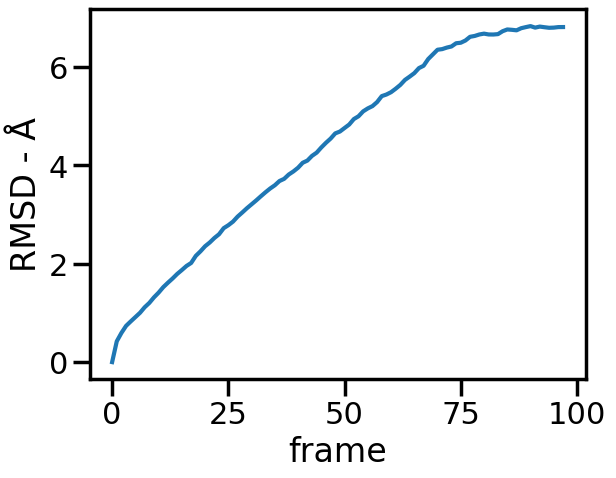

In [20]:
from matplotlib import pyplot as plt
from MDAnalysis.analysis.rms import RMSD
import seaborn as sns
sns.set_context('poster')
%matplotlib inline

u = mda.Universe(PSF, DCD)

c_alphas = u.select_atoms('name CA')

R = RMSD(c_alphas, c_alphas)
R.run()
plt.plot(R.results.rmsd.T[0], R.results.rmsd.T[2])
plt.xlabel('frame')
plt.ylabel('RMSD - Å')
plt.show()

# A summary of Lecture 1

Most simulation analysis will involve extracting position data from certain atoms.

- A Universe contains all information about a simulation system

- An `AtomGroup` contains information about a group of atoms

- We can use `Universe.select_atoms()` to create an `AtomGroup` containing specific atoms from a `Universe`

- Positions of atoms in an `AtomGroup` are accessed through `AtomGroup.positions`

# Workshop topics

- **Tutorial 1 :** Basics of MDAnalysis
  * Fundamental MDAnalysis objects
  * Atom selections
  * Visualising systems
  * Accessing bond, angle, and dihedral information


- **Tutorial 2:** Positions, distances, and trajectory 
  * Using position data
  * Calculating distances, bonds and angles
  * Accessing trajectory data

# Now - on to the first tutorial!

Find the tutorial notebook `Tutorial1_System_Manipulation` under: https://github.com/MDAnalysis/MDAnalysisWorkshop2023/notebooks/Tutorial1_System_Manipulation.ipynb

**Remember:**
- Go at your own pace!
- Ask questions!
- Take breaks!